<h1 align="center"> GASSMANN FLUID REPLACEMENT APPLICATION </h3>

<h3 align="center"> GASSMANN EQUATION </h3>
<h3 align="center"> TWO-MINERAL-MIXED ROCK SATURATED BY A TWO FLUID MIX </h3>

<h3> STUDENT: MASAPANTA POZO, John </h3>

Wednesday, 15th september, 2020\
Stavanger-Norway

**This python script has been built based on the following enunciate:**

<p style='text-align: justify;'> 
    
Consider a gas-saturated sandstone reservoir with porosity 30%. Assume 20% brine saturation (80% gas) completely mixed on fine scale. The measured P-wave velocity is 3040 m/s, the S-wave velocity is 1670 m/s. The reservoir rock consists on average of 80% quartz and 20% clay minerals. Use Hill’s average for the mineral mix.

**EXERCISE 3.3.** Compute the P-wave velocity, S-wave velocity and density for an 80% saturated oil reservoir (20% brine, mixed on fine scale).

**EXERCISE 3.4.** Plot the bulk density, the P-wave velocity and the S-wave velocity for the  gas-saturated reservoir as a function of brine saturation (Sw from 0 to 1) assuming complete fluid mixing. Cross-plot also the acoustic impedance versus the Vp/Vs ratio.

Assume identical reservoir rock.

**In other words,** the exercise ask for applying the fluid replacement algorithm considering an oil-brine saturated rock reservoir, which is also compossed of two different minerals, in order to understand how some properties such as: primary velocities (Vp), secondary velocities (Vs), and/or Accoustic Impedance (AI) vary ***if the reservoir were saturated by a brine and oil mix.***
    
</p>

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# A. PROBLEM 3.3

### Fluid replacement (Constant Water Saturation)

**Considerations:**

**1.** One mineral rock\
**2.** 100% Oil-saturated\
**3.** Porosity = 30 %

__DEFINING DATA:__

    poro  = Porosity [fraction]
    Vp    = Primary Velocity [m/s]
    Vs    = Secondary Velocity [m/s]
    Kw    = Brine Bulk Modulus [GPa]
    Ko    = Oil Bulk Modulus [GPa]
    Kg    = Gas Bulk Modulus [GPa]
    Kq    = Quartz Bulk Modulus [GPa]
    Gq    = Quartz Shear Modulus [GPa]
    rho_q = Quartz density [g/ccm]
    Kc    = Clay Bulk Modulus [GPa]
    Gc    = Clay Shear Modulus [GPa]
    rho_c = Clay density [g/ccm]
    
__ADDITIONAL DATA FOR MIXED MINERAL ROCKS AND MIXED FLUID SATURATION:__

    fr_q  = Quartz Fraction
    fr_c  = Clay Fraction
    s_w   = Brine Saturation
    s_g   = Gas Saturation

__NEW SATURATION DATA:__

    s_o_new   = New Brine Saturation for fluid replacement
    s_w_new   = New Gas Saturation for fluid replacement

In [3]:
#INPUTS
Kw    = 2.75
rho_w = 1.025
Ko    = 0.8
rho_o = 0.75
Kg    = 0.1
rho_g = 0.23
Kq    = 37
Gq    = 44
rho_q = 2.65
Kc    = 30
Gc    = 10
rho_c = 2.60

#INPUTS FROM A BRINE-GAS SATURATED MINERAL-MIX ROCK
poro  = 0.3
fr_q  = 0.8
fr_c  = 0.2
s_w   = 0.2
s_g   = 1 - s_w
Vp_wgs = 3040      #Primary and secondary velocities measured in an brine-gas saturated clay-quartz rock
Vs_wgs = 1670

#NEW SATURATION FRACTIONS FOR THE NEW ROCKS TO BE SATURATED
s_w_new   = 0.2
s_o_new   = 1 - s_w_new

In [4]:
#GASSMANN INVERTED EQUATION - K_dry

def Inv_Gassmann(poro, Vs_wgs, Vp_wgs, fr_c, rho_c, fr_q, rho_q, s_w, s_w_new, rho_o, rho_w, rho_g, Kc, Kq, Kw, Kg):
    
    #Mineral mix rock density (80% quartz and 20% clay) - [kg/m3]
    rho_m = (fr_c * rho_c + fr_q * rho_q)*1000
    
    #Fluid mix densities - [kg/m3]
    rho_wg = (s_w*rho_w + (1-s_w)*rho_g)*1000              #Brine-gas Fluid Mix
            
    #Saturated Rocks densities
    rho_wgs = ((1-poro)*rho_m + poro*rho_wg)               #Brine-gas saturated quartz material rock
        
    #Computing Modulus for the brine-gas saturated rock
    G_wgs = (Vs_wgs**2)*rho_wgs/10**9                  #Shear Modulus for an oil-saturated rock [Gpa]
    M_wgs = (Vp_wgs**2)*rho_wgs/10**9                  #M Modulus for an oil-saturated rock [GPa]
    K_wgs = M_wgs - 4*G_wgs/3                          #Bulk Modulus for an oil-saturated rock [GPa]
    
    #Computing the Moduli for the fluid mix and the mineral mix rock (Necessary priot to apply Inverted Gassmann Eq.)
    
    K_m_reuss = (fr_q/Kq + fr_c/Kc)**-1                #Bulk Modulus for mineral mix rock - [Gpa]
    K_m_voight = fr_q*Kq + fr_c*Kc
    K_m = (K_m_reuss + K_m_voight)/2                   #Hill's average
    
    Kwg = (s_w/Kw + s_g/Kg)**-1                        #Bulk Modulus for brine-gas fluid (Reuss Model) - [Gpa]
      
    #Inverted Gassmann Equation for computing K_dry
    a = K_wgs*(poro*K_m/Kwg+1-poro)-K_m
    b = (poro*K_m/Kwg)+(K_wgs/K_m)-1-poro
    K_dry = a/b                                        #Bulk Modulus for the dry or non-saturated rock - [GPa]
    G_dry = G_wgs

    results = K_dry, G_dry
    return results


In [5]:
#GASSMANN EQUATION - Fluid Replacement

def Gassmann(poro, fr_c, fr_q, Kq, Kc, s_w, s_w_new, Kg, Ko, Kw, K_dry, G_dry, rho_c, rho_q, Gq, rho_o, rho_g, rho_w):
    
 #Computing the Moduli for the fluid mix and the mineral mix rock (Necessary priot to apply Inverted Gassmann Eq.)
    
    K_m_reuss = (fr_q/Kq + fr_c/Kc)**-1                #Bulk Modulus for mineral mix rock - [Gpa]
    K_m_voight = fr_q*Kq + fr_c*Kc
    K_m = (K_m_reuss + K_m_voight)/2                   #Hill's average
    
    Kwg = (s_w/Kw + (1-s_w)/Kg)**-1                        #Bulk Modulus for brine-gas fluid (Reuss Model) - [Gpa]
    Kwo = (s_w_new/Kw + (1-s_w_new)/Ko)**-1                #Bulk Modulus for oil-gas fluid (Reuss Model) - [Gpa]
      
     #Gassmann Equation for fluid replacement - brine
    K_fluids = [Kwg, Kwo]
    K_fs_mat = []
    for K_f in K_fluids:
        c = (1-K_dry/K_m)**2
        d = poro/K_f + (1-poro)/K_m - K_dry/(K_m**2)
        K_s = K_dry + c/d
        K_fs_mat.append(K_s)                            #Bulk Modulus for an brine-gas and brine-oil saturated rock, respectively [GPa]
  
    M_fs_mat = []
    for K_fs in K_fs_mat:
        M_fs = K_fs + 4*G_dry/3
        M_fs_mat.append(M_fs)
    
    #Mineral mix rock density (80% quartz and 20% clay) - [kg/m3]
    rho_m = (fr_c * rho_c + fr_q * rho_q)*1000
    
    #Fluid mix densities - [kg/m3]
    rho_wg = (s_w*rho_w + (1-s_w)*rho_g)*1000              #Brine-gas Fluid Mix
    rho_wo = (s_w_new*rho_w + (1-s_w_new)*rho_o)*1000      #Oil-gas Fluid Mix
            
    #Saturated Rocks densities
    rho_wgs = ((1-poro)*rho_m + poro*rho_wg)           #Brine saturated quartz material rock
    rho_wos = ((1-poro)*rho_m + poro*rho_wo)           #Oil saturated quartz material rock - used for inverted Gassmann Equation
        
    rho_mat = [rho_wgs, rho_wos]
    Vp_mat = []
    Vs_mat = []
    for i in range(len(rho_mat)):      
        Vp_s = (M_fs_mat[i]*10**9/rho_mat[i])**(1/2)
        Vp_mat.append(Vp_s)                            #P-Velocities for brine-gas and brine-oil saturated rock, respectively [GPa]
        Vs_s = (G_dry*10**9/rho_mat[i])**(1/2)
        Vs_mat.append(Vs_s)                            #S-Velocities for brine-gas and brine-oil saturated rock, respectively [GPa]
           
    AI_mat = []                                        #Acoustic Impedance and Vp/Vs ratio Calculation
    Vp_Vs_mat = []
    for i in range(len(Vp_mat)):
        AI_s = Vp_mat[i]*rho_mat[i]
        AI_mat.append(AI_s)
        
        Vp_Vs = Vp_mat[i]/Vs_mat[i]
        Vp_Vs_mat.append(Vp_Vs)
        
    results = [poro, AI_mat[0], AI_mat[1], Vp_Vs_mat[0], Vp_Vs_mat[1], Vp_mat[0], Vp_mat[1], Vs_mat[0], Vs_mat[1], rho_mat[0], rho_mat[1]]
    return results


In [6]:
#Calling Inv_Gassmann function - Kdry
K_dry = Inv_Gassmann(poro, Vs_wgs, Vp_wgs, fr_c, rho_c, fr_q, rho_q, s_w, 
                     s_w_new, rho_o, rho_w, rho_g, Kc, Kq, Kw, Kg)

#Calling Gassmann Function - Velocities
results = Gassmann(poro, fr_c, fr_q, Kq, Kc, s_w, s_w_new, Kg, Ko, Kw, 
                   K_dry[0], K_dry[1], rho_c, rho_q, Gq, rho_o, rho_g, rho_w)


labels = ["Porosity = ", "AI_brine_gas = ", "AI_brine_oil = ", "Vs/Vs_brine_gas = ", "Vs/Vs_brine_oil = ",
          "Vp_brine_gas = ", "Vp_brine_oil = ", "Vs_brine_gas = ", "Vs_brine_oil = ",
          "Density brine_gas-sat rock = ", "Density brine_oil-sat rock = "]

for i in range(len(results)):
    r = labels[i] + str(round(results[i], 4))
    print(r)


Porosity = 0.3
AI_brine_gas = 5972688.0
AI_brine_oil = 6371063.1545
Vs/Vs_brine_gas = 1.8204
Vs/Vs_brine_oil = 1.8829
Vp_brine_gas = 3040.0
Vp_brine_oil = 3049.085
Vs_brine_gas = 1670.0
Vs_brine_oil = 1619.36
Density brine_gas-sat rock = 1964.7
Density brine_oil-sat rock = 2089.5


Note: The size of the circles in the plot are 200 times proportional to the porosity.
In other words, the bigest ones represent the highest posorities values and vice versa


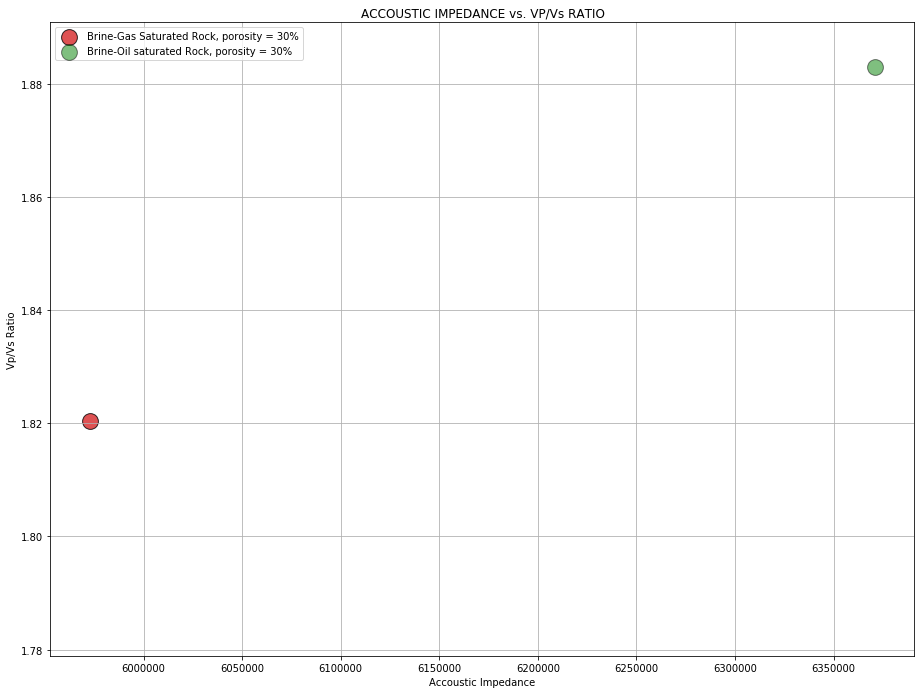

In [7]:
#Plotting

#Plotting Results AI versus VP/VS for brine, oil and gas saturated rocks with 30% porosity

fig, ax = plt.subplots()
                                 
ax.scatter(results[1], results[3], c="tab:red", s=250,
               alpha=0.8, edgecolors='black')
ax.scatter(results[2], results[4], c="green", s=250,
               alpha=0.5, edgecolors='black')

plt.xlabel('Accoustic Impedance'); plt.ylabel('Vp/Vs Ratio'); plt.title('ACCOUSTIC IMPEDANCE vs. VP/Vs RATIO')
ax.legend(["Brine-Gas Saturated Rock, porosity = 30%", "Brine-Oil saturated Rock, porosity = 30%"], loc = 'upper left')
ax.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.2, hspace=0.3)
#plt.show()

print("""Note: The size of the circles in the plot are 200 times proportional to the porosity.
In other words, the bigest ones represent the highest posorities values and vice versa""")

# PROBLEM 3.4.

Going further into the previous exercise, we can vary the porosity and understand how **Accoustic Impedance and Wave Velocities vary as functions of SATURATION.**

### Fluid Replacement (Different Water Saturations)

**Considerations:**

**1.** Two mineral rock -- 80% quartz and 20% clay\
**2.** Brine-gas saturated -- 20% brine and 80% gas

In [8]:
#Gassman Equation using different saturations (FIRST TRY)

#Calling Gassmann Function - Velocities

def Gassmann_Sat(poro, fr_c, fr_q, Kq, Kc, sat_array, s_w_new, Kg, Ko, Kw, 
                 K_dry, G_dry, rho_c, rho_q, Gq, rho_o, rho_g, rho_w):
    
    results_sat = []
    for s_w in sat_array:
        s_w_new = s_w
        value = Gassmann(poro, fr_c, fr_q, Kq, Kc, s_w, s_w_new, Kg, Ko, Kw, 
                 K_dry, G_dry, rho_c, rho_q, Gq, rho_o, rho_g, rho_w)
        #results_poro[poro]= value
        results_sat.append(value)
    
    df_results = pd.DataFrame(results_sat, columns=["Porosity", "AI_bg", "AI_bo", "V_Ratio_bg", "V_Ratio_bo", "Vp_bg", "Vp_bo", "Vs_bg", "Vs_bo", "rho_bg", "rho_bo"], index=None)
    df_results["Saturation"] = sat_array

    #return results_poro
    return df_results

In [9]:
#Calling Gassmann Function with porosities from 0.1 to 0.9 and displaying results

saturations = np.arange(0,1.05,0.05)

results2 = Gassmann_Sat(poro, fr_c, fr_q, Kq, Kc, saturations, s_w_new, Kg, Ko, Kw, 
                 K_dry[0], K_dry[1], rho_c, rho_q, Gq, rho_o, rho_g, rho_w)
display(results2)

,Porosity,AI_bg,AI_bo,V_Ratio_bg,V_Ratio_bo,Vp_bg,Vp_bo,Vs_bg,Vs_bo,rho_bg,rho_bo,Saturation
0,0.3,5.893457e+06,6.312710e+06,1.818421,1.873059,3074.312294,3045.204810,1690.649332,1625.791852,1917.000,2073.000,0.00
1,0.3,5.913096e+06,6.326411e+06,1.818832,1.875260,3065.487999,3045.753426,1685.415264,1624.176705,1928.925,2077.125,0.05
2,0.3,5.932830e+06,6.340660e+06,1.819287,1.877620,3056.820525,3046.563248,1680.229509,1622.566362,1940.850,2081.250,0.10
3,0.3,5.952683e+06,6.355520e+06,1.819793,1.880158,3048.320166,3047.662785,1675.091329,1620.960800,1952.775,2085.375,0.15
4,0.3,5.972688e+06,6.371063e+06,1.820359,1.882895,3040.000000,3049.085023,1670.000000,1619.359994,1964.700,2089.500,0.20
5,0.3,5.992883e+06,6.387374e+06,1.820996,1.885855,3031.876759,3050.868334,1664.954815,1617.763922,1976.625,2093.625,0.25
6,0.3,6.013320e+06,6.404552e+06,1.821719,1.889067,3023.972043,3053.057628,1659.955081,1616.172560,1988.550,2097.750,0.30
7,0.3,6.034061e+06,6.422712e+06,1.822546,1.892563,3016.314065,3055.705798,1655.000120,1614.585885,2000.475,2101.875,0.35
8,0.3,6.055191e+06,6.441992e+06,1.823501,1.896385,3008.940209,3058.875581,1650.089267,1613.003873,2012.400,2106.000,0.40
9,0.3,6.076823e+06,6.462557e+06,1.824618,1.900578,3001.900877,3062.641960,1645.221872,1611.426503,2024.325,2110.125,0.45


Note: The size of the circles in the plot are 300 times proportional to the porosity.
In other words, the bigest ones represent the highest posorities values and vice versa


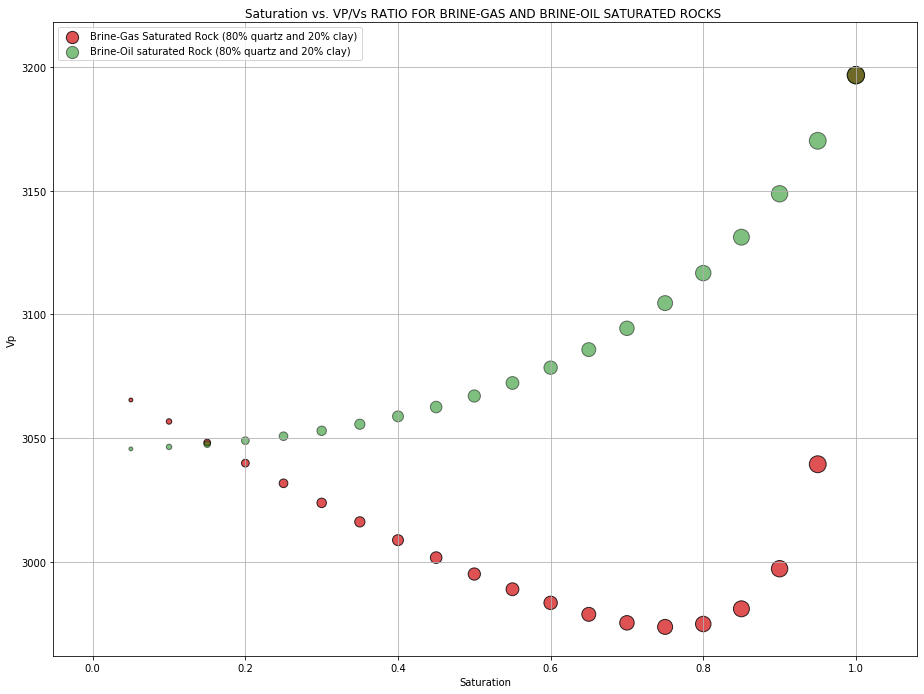

In [14]:
#Plotting Results density vs vp for Brine-gas and Brine-Oil saturated rocks as a function of porosity

fig, ax = plt.subplots()

scale = 300 * results2["Saturation"]                                   
ax.scatter(results2["Saturation"], results2["Vp_bg"], c="tab:red", s=scale,
               alpha=0.8, edgecolors='black')
ax.scatter(results2["Saturation"], results2["Vp_bo"], c="green", s=scale,
               alpha=0.5, edgecolors='black')

plt.xlabel("Saturation"); plt.ylabel('Vp')
plt.title('Saturation vs. VP/Vs RATIO FOR BRINE-GAS AND BRINE-OIL SATURATED ROCKS ')
ax.legend(["Brine-Gas Saturated Rock (80% quartz and 20% clay)", "Brine-Oil saturated Rock (80% quartz and 20% clay)"], loc = 'upper left')
ax.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.2, hspace=0.3)
#plt.show()

print("""Note: The size of the circles in the plot are 300 times proportional to the porosity.
In other words, the bigest ones represent the highest posorities values and vice versa""")

Note: The size of the circles in the plot are 300 times proportional to the porosity.
In other words, the bigest ones represent the highest posorities values and vice versa


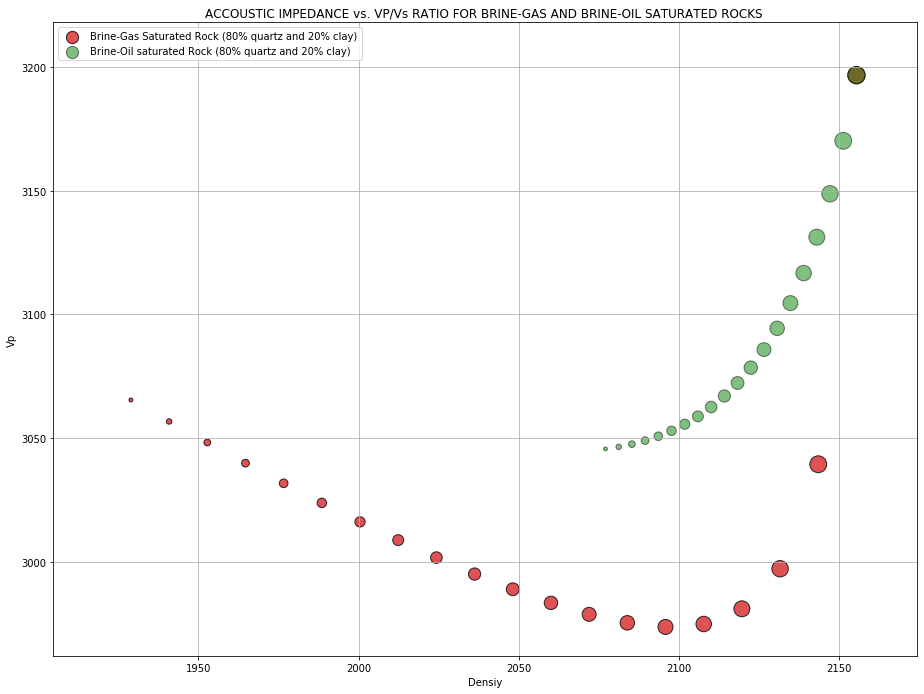

In [12]:
#Plotting Results density vs vp for Brine-gas and Brine-Oil saturated rocks as a function of porosity

fig, ax = plt.subplots()

scale = 300 * results2["Saturation"]                                   
ax.scatter(results2["rho_bg"], results2["Vp_bg"], c="tab:red", s=scale,
               alpha=0.8, edgecolors='black')
ax.scatter(results2["rho_bo"], results2["Vp_bo"], c="green", s=scale,
               alpha=0.5, edgecolors='black')

plt.xlabel("Densiy"); plt.ylabel('Vp')
plt.title('ACCOUSTIC IMPEDANCE vs. VP/Vs RATIO FOR BRINE-GAS AND BRINE-OIL SATURATED ROCKS ')
ax.legend(["Brine-Gas Saturated Rock (80% quartz and 20% clay)", "Brine-Oil saturated Rock (80% quartz and 20% clay)"], loc = 'upper left')
ax.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.2, hspace=0.3)
#plt.show()

print("""Note: The size of the circles in the plot are 300 times proportional to the porosity.
In other words, the bigest ones represent the highest posorities values and vice versa""")

Note: The size of the circles in the plot are 300 times proportional to the porosity.
In other words, the bigest ones represent the highest posorities values and vice versa


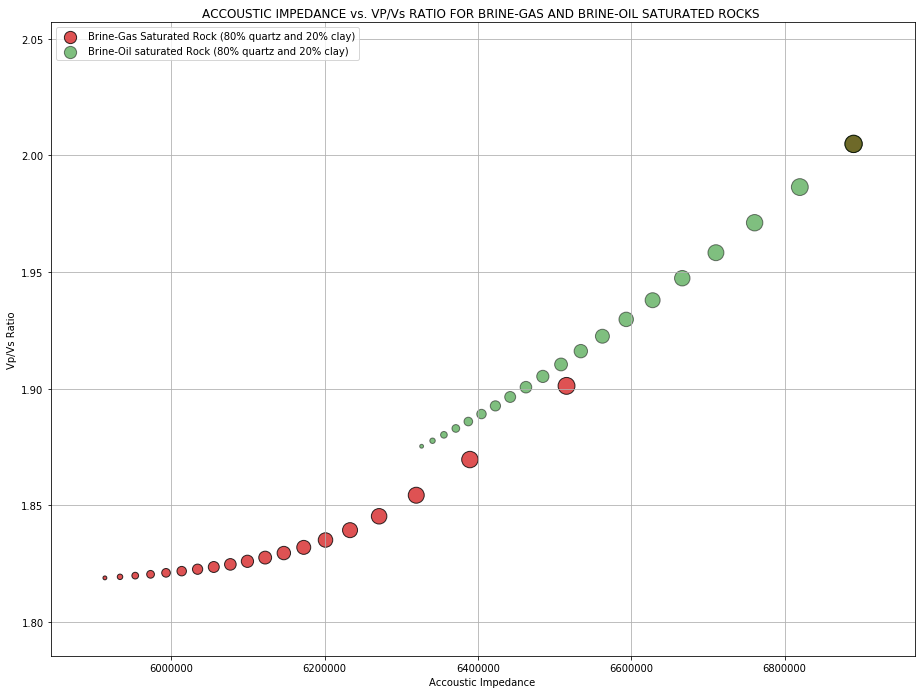

In [10]:
#Plotting Results AI versus VP/VS for Brine-gas and Brine-Oil saturated rocks as a function of porosity

fig, ax = plt.subplots()

scale = 300 * results2["Saturation"]                                   
ax.scatter(results2["AI_bg"], results2["V_Ratio_bg"], c="tab:red", s=scale,
               alpha=0.8, edgecolors='black')
ax.scatter(results2["AI_bo"], results2["V_Ratio_bo"], c="green", s=scale,
               alpha=0.5, edgecolors='black')

plt.xlabel('Accoustic Impedance'); plt.ylabel('Vp/Vs Ratio')
plt.title('ACCOUSTIC IMPEDANCE vs. VP/Vs RATIO FOR BRINE-GAS AND BRINE-OIL SATURATED ROCKS ')
ax.legend(["Brine-Gas Saturated Rock (80% quartz and 20% clay)", "Brine-Oil saturated Rock (80% quartz and 20% clay)"], loc = 'upper left')
ax.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.2, hspace=0.3)
#plt.show()

print("""Note: The size of the circles in the plot are 300 times proportional to the porosity.
In other words, the bigest ones represent the highest posorities values and vice versa""")

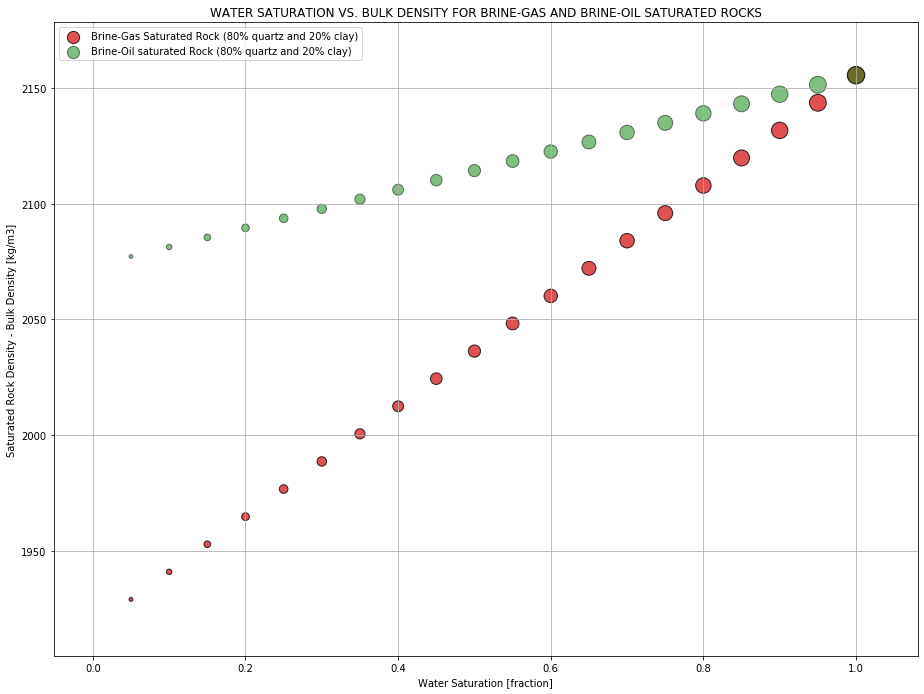

In [10]:
#Plotting Water Saturation vs. Bulk Density for Brine-gas and Brine-Oil saturated rocks

fig, ax = plt.subplots()

scale = 300 * results2["Saturation"]  
ax.scatter(results2["Saturation"], results2["rho_bg"], c="tab:red", s=scale,
               alpha=0.8, edgecolors='black')
ax.scatter(results2["Saturation"], results2["rho_bo"], c="green", s=scale,
               alpha=0.5, edgecolors='black')

plt.xlabel('Water Saturation [fraction]'); plt.ylabel('Saturated Rock Density - Bulk Density [kg/m3]')
plt.title('WATER SATURATION VS. BULK DENSITY FOR BRINE-GAS AND BRINE-OIL SATURATED ROCKS')
ax.legend(["Brine-Gas Saturated Rock (80% quartz and 20% clay)", "Brine-Oil saturated Rock (80% quartz and 20% clay)"], loc = 'upper left')
ax.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.2, hspace=0.3)
#plt.show()

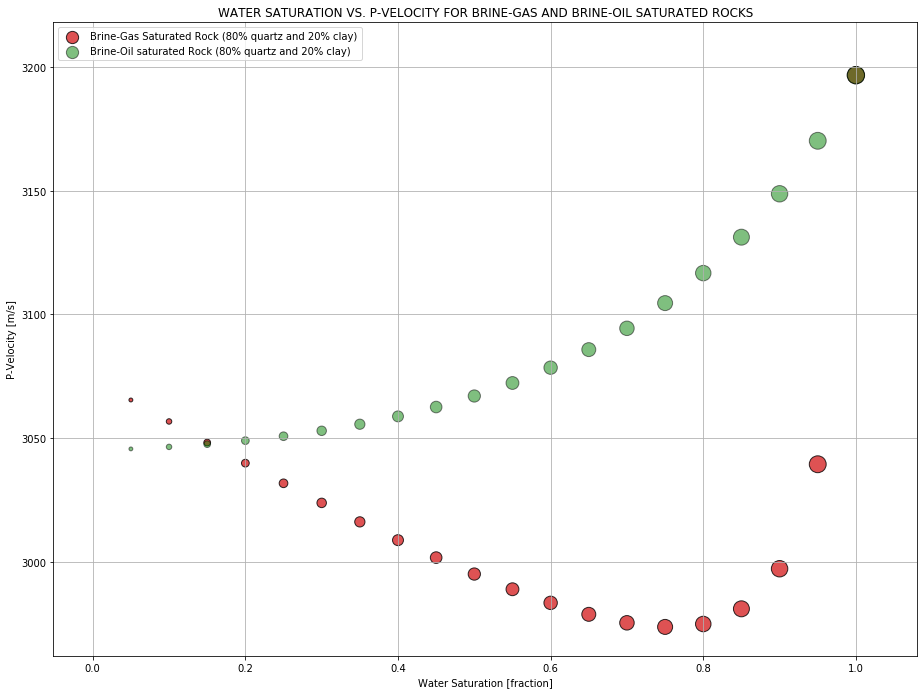

In [11]:
#Plotting Saturation vs. P-wave velocity for Brine-gas and Brine-Oil saturated rocks

fig, ax = plt.subplots()

scale = 300 * results2["Saturation"]  
ax.scatter(results2["Saturation"], results2["Vp_bg"], c="tab:red", s=scale,
               alpha=0.8, edgecolors='black')
ax.scatter(results2["Saturation"], results2["Vp_bo"], c="green", s=scale,
               alpha=0.5, edgecolors='black')

plt.xlabel('Water Saturation [fraction]'); plt.ylabel('P-Velocity [m/s]')
plt.title('WATER SATURATION VS. P-VELOCITY FOR BRINE-GAS AND BRINE-OIL SATURATED ROCKS')
ax.legend(["Brine-Gas Saturated Rock (80% quartz and 20% clay)", "Brine-Oil saturated Rock (80% quartz and 20% clay)"], loc = 'upper left')
ax.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.2, hspace=0.3)
#plt.show()

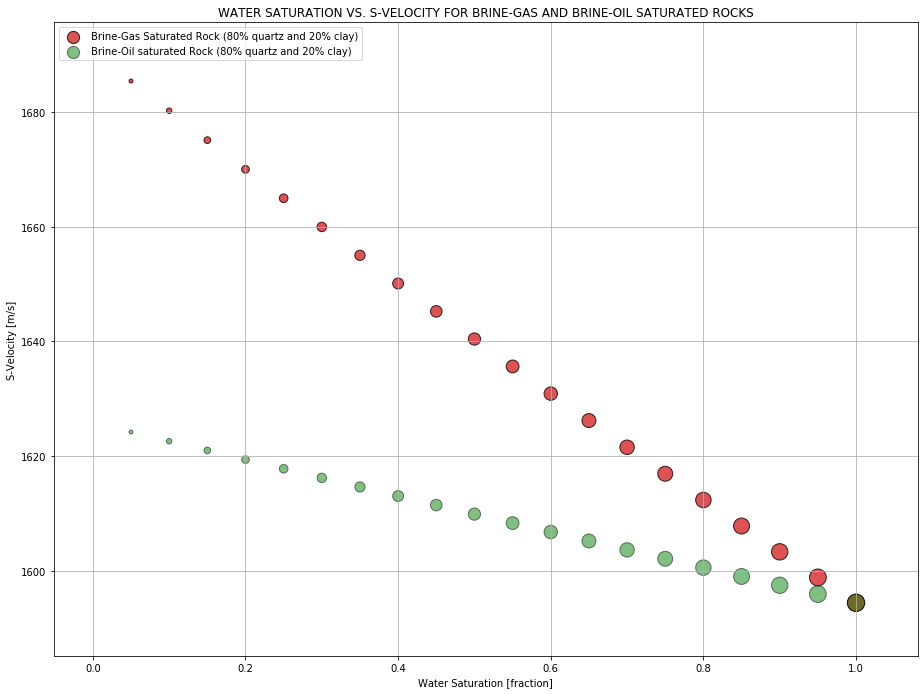

In [12]:
#Plotting Saturation vs. S-wave velocity for Brine-gas and Brine-Oil saturated rocks

fig, ax = plt.subplots()

scale = 300 * results2["Saturation"]  
ax.scatter(results2["Saturation"], results2["Vs_bg"], c="tab:red", s=scale,
               alpha=0.8, edgecolors='black')
ax.scatter(results2["Saturation"], results2["Vs_bo"], c="green", s=scale,
               alpha=0.5, edgecolors='black')

plt.xlabel('Water Saturation [fraction]'); plt.ylabel('S-Velocity [m/s]')
plt.title('WATER SATURATION VS. S-VELOCITY FOR BRINE-GAS AND BRINE-OIL SATURATED ROCKS')
ax.legend(["Brine-Gas Saturated Rock (80% quartz and 20% clay)", "Brine-Oil saturated Rock (80% quartz and 20% clay)"], loc = 'upper left')
ax.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.2, hspace=0.3)
#plt.show()

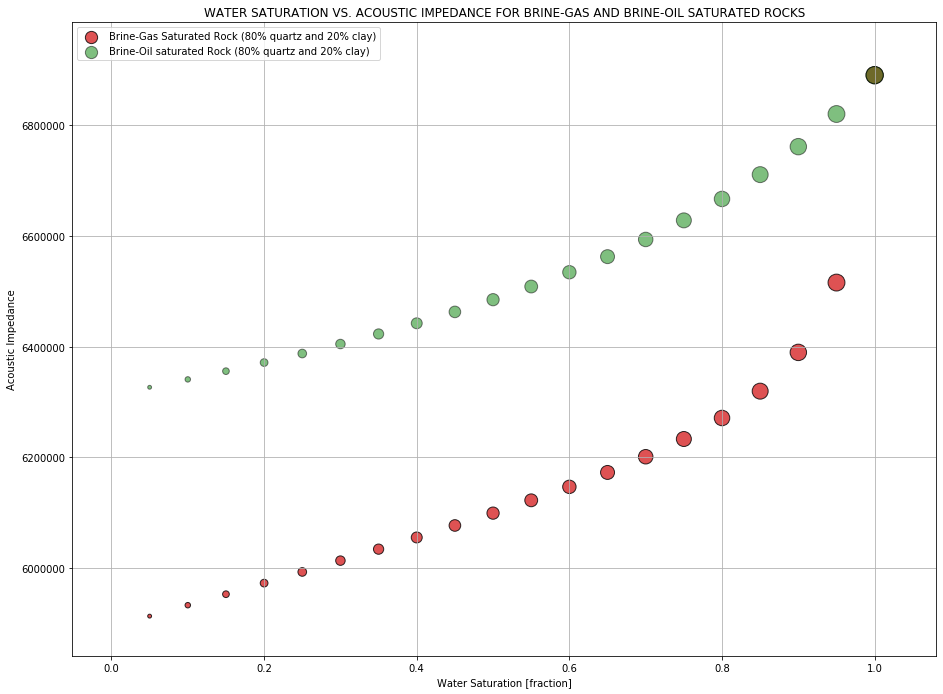

In [13]:
#Plotting Saturation vs. Aciustic Impedance for Brine-gas and Brine-Oil saturated rocks

fig, ax = plt.subplots()

scale = 300 * results2["Saturation"]  
ax.scatter(results2["Saturation"], results2["AI_bg"], c="tab:red", s=scale,
               alpha=0.8, edgecolors='black')
ax.scatter(results2["Saturation"], results2["AI_bo"], c="green", s=scale,
               alpha=0.5, edgecolors='black')

plt.xlabel('Water Saturation [fraction]'); plt.ylabel('Acoustic Impedance')
plt.title('WATER SATURATION VS. ACOUSTIC IMPEDANCE FOR BRINE-GAS AND BRINE-OIL SATURATED ROCKS')
ax.legend(["Brine-Gas Saturated Rock (80% quartz and 20% clay)", "Brine-Oil saturated Rock (80% quartz and 20% clay)"], loc = 'upper left')
ax.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.2, hspace=0.3)
#plt.show()

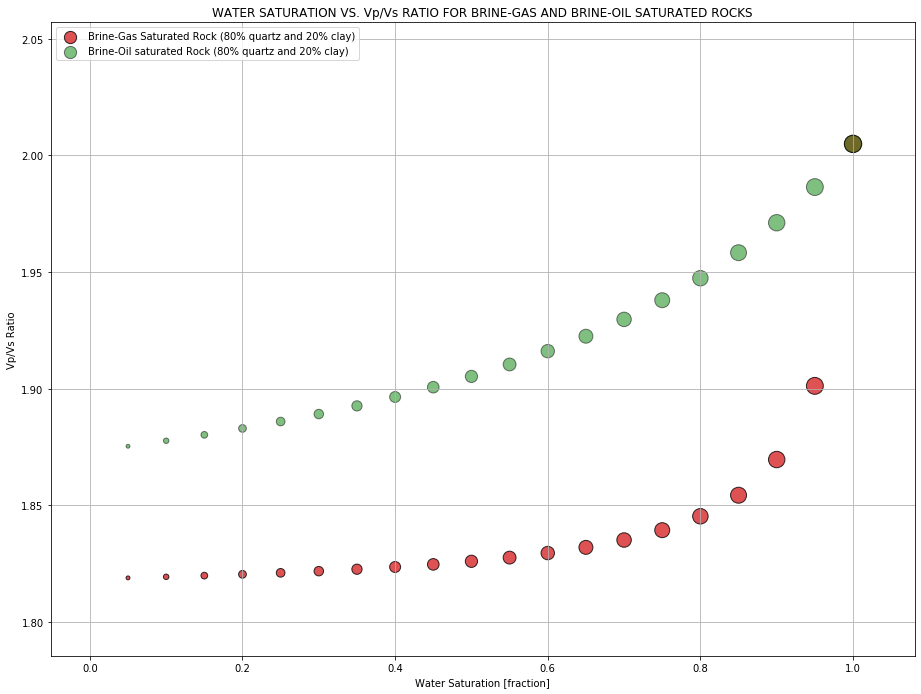

In [14]:
#Plotting Saturation vs. Vp/Vs ratio for Brine-gas and Brine-Oil saturated rocks

fig, ax = plt.subplots()

scale = 300 * results2["Saturation"]  
ax.scatter(results2["Saturation"], results2["V_Ratio_bg"], c="tab:red", s=scale,
               alpha=0.8, edgecolors='black')
ax.scatter(results2["Saturation"], results2["V_Ratio_bo"], c="green", s=scale,
               alpha=0.5, edgecolors='black')

plt.xlabel('Water Saturation [fraction]'); plt.ylabel('Vp/Vs Ratio')
plt.title('WATER SATURATION VS. Vp/Vs RATIO FOR BRINE-GAS AND BRINE-OIL SATURATED ROCKS')
ax.legend(["Brine-Gas Saturated Rock (80% quartz and 20% clay)", "Brine-Oil saturated Rock (80% quartz and 20% clay)"], loc = 'upper left')
ax.grid(True)

plt.subplots_adjust(left=0.0, bottom=0.0, right=2.0, top=2.2, wspace=0.2, hspace=0.3)
#plt.show()